# Linear models

In [ ]:
"""
rwc_linear_regression_optuna.py
------------------------
1) Load dataset: dataset_completo.xlsx
2) Exclude 'day' and 'individual' from predictors
3) Fit linear models (LinearRegression, Ridge, Lasso, ElasticNet) with Optuna to find best hyperparameters
4) Save coefficients, predictions, and a scatter plot
"""

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import r2_score, mean_absolute_error
import optuna #metion that library because it is extremely useful to the hyperparameters of our models!!!  <---------------------------------------------------------------

# =================== USER SETTINGS ===================
FILE_PATH   = r"C:\Users\ritaj\Documents\R\Rabanitos\datasets\dataset_completo.xlsx"
TARGET_COL  = "water_percentage"
TEST_SIZE   = 0.2
RANDOM_STATE= 42
OUT_DIR     = Path("outputs_optuna")
# =====================================================

# ---------- Load dataset ----------
df = pd.read_excel(FILE_PATH)
print(f"Dataset loaded: {len(df)} rows, {len(df.columns)} columns")

# ---------- Prepare predictors ----------
y = df[TARGET_COL].astype(float)
X = df.drop(columns=[TARGET_COL])
X = X.select_dtypes(include=[np.number])  # only numeric
for col in ["day", "individual"]:
    if col in X.columns:
        X = X.drop(columns=[col])

# Drop rows with NA
mask = ~(X.isna().any(axis=1) | y.isna())
X, y = X[mask], y[mask]

print(f"Rows after NA drop: {len(X)}")
print("Predictors used:", list(X.columns))

# ---------- Train/test split ----------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

# ---------- Optuna objective function ----------
def objective(trial, model_name):
    if model_name == "Ridge":
        alpha = trial.suggest_loguniform("alpha", 1e-4, 10.0)
        model = Ridge(alpha=alpha, random_state=RANDOM_STATE)
    elif model_name == "Lasso":
        alpha = trial.suggest_loguniform("alpha", 1e-4, 1.0)
        model = Lasso(alpha=alpha, random_state=RANDOM_STATE, max_iter=10000)
    elif model_name == "ElasticNet":
        alpha = trial.suggest_loguniform("alpha", 1e-4, 1.0)
        l1_ratio = trial.suggest_float("l1_ratio", 0.0, 1.0)
        model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=RANDOM_STATE, max_iter=10000)
    else:  # LinearRegression has no hyperparameters
        model = LinearRegression()

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    return -r2  # Optuna minimizes by default

# ---------- Fit models with Optuna ----------
models = ["LinearRegression", "Ridge", "Lasso", "ElasticNet"]
best_models = {}

for m in models:
    if m == "LinearRegression":
        model = LinearRegression()
        model.fit(X_train, y_train)
        best_models[m] = model
        print(f"{m} fitted with default parameters")
    else:
        study = optuna.create_study(direction="minimize")
        study.optimize(lambda trial: objective(trial, m), n_trials=50, show_progress_bar=True)
        best_params = study.best_params
        if m == "Ridge":
            model = Ridge(**best_params, random_state=RANDOM_STATE)
        elif m == "Lasso":
            model = Lasso(**best_params, random_state=RANDOM_STATE, max_iter=10000)
        elif m == "ElasticNet":
            model = ElasticNet(**best_params, random_state=RANDOM_STATE, max_iter=10000)
        model.fit(X_train, y_train)
        best_models[m] = model
        print(f"{m} fitted with best params: {best_params}")

# ---------- Evaluate and save outputs ----------
OUT_DIR.mkdir(exist_ok=True)

for name, model in best_models.items():
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"{name} | Test R^2={r2:.3f}, MAE={mae:.3f}")

    # Save coefficients
    coef_df = pd.DataFrame({
        "feature": X.columns,
        "coefficient": model.coef_
    }).sort_values("coefficient", key=lambda s: np.abs(s), ascending=False)
    coef_df = pd.concat([pd.DataFrame([{"feature": "INTERCEPT", "coefficient": model.intercept_}]), coef_df], ignore_index=True)
    coef_path = OUT_DIR / f"{name}_coefficients.csv"
    coef_df.to_csv(coef_path, index=False)

    # Save predictions
    pred_df = pd.DataFrame({
        "y_true": y_test.values,
        "y_pred": y_pred
    })
    pred_path = OUT_DIR / f"{name}_predictions.csv"
    pred_df.to_csv(pred_path, index=False)

    # Scatter plot
    plt.figure(figsize=(5,5))
    plt.scatter(y_test, y_pred)
    lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
    plt.plot(lims, lims, 'r--')
    plt.xlabel("True water %")
    plt.ylabel("Predicted water %")
    plt.title(f"{name}: True vs Predicted")
    plt.tight_layout()
    plt.savefig(OUT_DIR / f"{name}_scatter.png", dpi=200)
    plt.close()

print("All outputs saved in", OUT_DIR.resolve())



[I 2025-08-19 14:39:46,783] A new study created in memory with name: no-name-aac44539-6610-4647-9b8e-a0b75083b94a


Dataset loaded: 1359 rows, 19 columns
Rows after NA drop: 1359
Predictors used: ['ASM (Energy)', 'Contrast', 'Correlation', 'Variance', 'IDM (Homogeneity)', 'Sum Average', 'Sum Variance', 'Sum Entropy', 'Entropy', 'Difference Variance', 'Difference Entropy', 'IMC1 (Info Measure Corr 1)', 'IMC2 (Info Measure Corr 2)']
LinearRegression fitted with default parameters


  0%|          | 0/50 [00:00<?, ?it/s]C:\Users\ritaj\AppData\Local\Temp\ipykernel_18800\3806018715.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform("alpha", 1e-4, 10.0)
Best trial: 0. Best value: -0.0770258:   0%|          | 0/50 [00:00<?, ?it/s]C:\Users\ritaj\AppData\Local\Temp\ipykernel_18800\3806018715.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform("alpha", 1e-4, 10.0)
Best trial: 1. Best value: -0.0932054:   2%|▏         | 1/50 [00:00<00:01, 38.35it/s]C:\Users\ritaj\AppData\Local\Temp\ipykernel_18800\3806018715.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feat

[I 2025-08-19 14:39:46,798] Trial 0 finished with value: -0.07702580904875389 and parameters: {'alpha': 0.037159225727659506}. Best is trial 0 with value: -0.07702580904875389.
[I 2025-08-19 14:39:46,810] Trial 1 finished with value: -0.09320537152571307 and parameters: {'alpha': 0.004922402914835911}. Best is trial 1 with value: -0.09320537152571307.
[I 2025-08-19 14:39:46,829] Trial 2 finished with value: -0.10264724850241014 and parameters: {'alpha': 0.00012288704205010043}. Best is trial 2 with value: -0.10264724850241014.
[I 2025-08-19 14:39:46,844] Trial 3 finished with value: -0.06555329204632865 and parameters: {'alpha': 4.986589184348697}. Best is trial 2 with value: -0.10264724850241014.
[I 2025-08-19 14:39:46,860] Trial 4 finished with value: -0.0678758886205898 and parameters: {'alpha': 1.8494723974966516}. Best is trial 2 with value: -0.10264724850241014.
[I 2025-08-19 14:39:46,868] Trial 5 finished with value: -0.06574839296108048 and parameters: {'alpha': 4.5376431126738

C:\Users\ritaj\AppData\Local\Temp\ipykernel_18800\3806018715.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform("alpha", 1e-4, 10.0)
Best trial: 11. Best value: -0.102699:  22%|██▏       | 11/50 [00:00<00:00, 64.64it/s]C:\Users\ritaj\AppData\Local\Temp\ipykernel_18800\3806018715.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform("alpha", 1e-4, 10.0)
Best trial: 12. Best value: -0.102828:  24%|██▍       | 12/50 [00:00<00:00, 64.64it/s]C:\Users\ritaj\AppData\Local\Temp\ipykernel_18800\3806018715.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.

[I 2025-08-19 14:39:46,962] Trial 11 finished with value: -0.10269851894426407 and parameters: {'alpha': 0.00013995188413087764}. Best is trial 11 with value: -0.10269851894426407.
[I 2025-08-19 14:39:46,977] Trial 12 finished with value: -0.10282764160827362 and parameters: {'alpha': 0.000190323598743436}. Best is trial 12 with value: -0.10282764160827362.


Best trial: 12. Best value: -0.102828:  28%|██▊       | 14/50 [00:00<00:00, 61.83it/s]C:\Users\ritaj\AppData\Local\Temp\ipykernel_18800\3806018715.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform("alpha", 1e-4, 10.0)
Best trial: 12. Best value: -0.102828:  28%|██▊       | 14/50 [00:00<00:00, 61.83it/s]C:\Users\ritaj\AppData\Local\Temp\ipykernel_18800\3806018715.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform("alpha", 1e-4, 10.0)
Best trial: 12. Best value: -0.102828:  30%|███       | 15/50 [00:00<00:00, 61.83it/s]C:\Users\ritaj\AppData\Local\Temp\ipykernel_18800\3806018715.py:54: FutureWarning: s

[I 2025-08-19 14:39:46,993] Trial 13 finished with value: -0.10281758546834774 and parameters: {'alpha': 0.0007507085049297826}. Best is trial 12 with value: -0.10282764160827362.
[I 2025-08-19 14:39:47,045] Trial 14 finished with value: -0.10223779398979604 and parameters: {'alpha': 0.0010557359903128787}. Best is trial 12 with value: -0.10282764160827362.
[I 2025-08-19 14:39:47,072] Trial 15 finished with value: -0.10200252302542934 and parameters: {'alpha': 0.0011584581381380724}. Best is trial 12 with value: -0.10282764160827362.
[I 2025-08-19 14:39:47,102] Trial 16 finished with value: -0.10287076789181937 and parameters: {'alpha': 0.0007137247431768324}. Best is trial 16 with value: -0.10287076789181937.
[I 2025-08-19 14:39:47,126] Trial 17 finished with value: -0.09199222824962738 and parameters: {'alpha': 0.00563597266298223}. Best is trial 16 with value: -0.10287076789181937.


Best trial: 18. Best value: -0.10308:  36%|███▌      | 18/50 [00:00<00:00, 61.83it/s] C:\Users\ritaj\AppData\Local\Temp\ipykernel_18800\3806018715.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform("alpha", 1e-4, 10.0)
Best trial: 18. Best value: -0.10308:  38%|███▊      | 19/50 [00:00<00:00, 61.83it/s]C:\Users\ritaj\AppData\Local\Temp\ipykernel_18800\3806018715.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform("alpha", 1e-4, 10.0)


[I 2025-08-19 14:39:47,143] Trial 18 finished with value: -0.10307972023934553 and parameters: {'alpha': 0.00043215723559591356}. Best is trial 18 with value: -0.10307972023934553.
[I 2025-08-19 14:39:47,162] Trial 19 finished with value: -0.0926257670667403 and parameters: {'alpha': 0.005253636355869106}. Best is trial 18 with value: -0.10307972023934553.


Best trial: 18. Best value: -0.10308:  42%|████▏     | 21/50 [00:00<00:00, 48.29it/s]C:\Users\ritaj\AppData\Local\Temp\ipykernel_18800\3806018715.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform("alpha", 1e-4, 10.0)
Best trial: 18. Best value: -0.10308:  42%|████▏     | 21/50 [00:00<00:00, 48.29it/s]C:\Users\ritaj\AppData\Local\Temp\ipykernel_18800\3806018715.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform("alpha", 1e-4, 10.0)
Best trial: 18. Best value: -0.10308:  44%|████▍     | 22/50 [00:00<00:00, 48.29it/s]C:\Users\ritaj\AppData\Local\Temp\ipykernel_18800\3806018715.py:54: FutureWarning: sugg

[I 2025-08-19 14:39:47,186] Trial 20 finished with value: -0.07714942196269226 and parameters: {'alpha': 0.03628036304479686}. Best is trial 18 with value: -0.10307972023934553.
[I 2025-08-19 14:39:47,204] Trial 21 finished with value: -0.10306352002256747 and parameters: {'alpha': 0.00037025922279987925}. Best is trial 18 with value: -0.10307972023934553.
[I 2025-08-19 14:39:47,219] Trial 22 finished with value: -0.10307960865311283 and parameters: {'alpha': 0.00042984617317074977}. Best is trial 18 with value: -0.10307972023934553.
[I 2025-08-19 14:39:47,232] Trial 23 finished with value: -0.103060533241774 and parameters: {'alpha': 0.0003644783463377906}. Best is trial 18 with value: -0.10307972023934553.
[I 2025-08-19 14:39:47,232] Trial 24 finished with value: -0.099700524878378 and parameters: {'alpha': 0.0020392670259391462}. Best is trial 18 with value: -0.10307972023934553.
[I 2025-08-19 14:39:47,250] Trial 25 finished with value: -0.1030570815448053 and parameters: {'alpha': 

Best trial: 18. Best value: -0.10308:  64%|██████▍   | 32/50 [00:00<00:00, 58.13it/s]C:\Users\ritaj\AppData\Local\Temp\ipykernel_18800\3806018715.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform("alpha", 1e-4, 10.0)
Best trial: 18. Best value: -0.10308:  66%|██████▌   | 33/50 [00:00<00:00, 58.13it/s]C:\Users\ritaj\AppData\Local\Temp\ipykernel_18800\3806018715.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform("alpha", 1e-4, 10.0)


[I 2025-08-19 14:39:47,334] Trial 32 finished with value: -0.10306839784878674 and parameters: {'alpha': 0.0004978026248638471}. Best is trial 18 with value: -0.10307972023934553.
[I 2025-08-19 14:39:47,351] Trial 33 finished with value: -0.09937140237661723 and parameters: {'alpha': 0.0021624311732107953}. Best is trial 18 with value: -0.10307972023934553.


Best trial: 18. Best value: -0.10308:  68%|██████▊   | 34/50 [00:00<00:00, 58.13it/s]C:\Users\ritaj\AppData\Local\Temp\ipykernel_18800\3806018715.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform("alpha", 1e-4, 10.0)
Best trial: 18. Best value: -0.10308:  70%|███████   | 35/50 [00:00<00:00, 58.13it/s]C:\Users\ritaj\AppData\Local\Temp\ipykernel_18800\3806018715.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform("alpha", 1e-4, 10.0)
Best trial: 18. Best value: -0.10308:  74%|███████▍  | 37/50 [00:00<00:00, 63.76it/s]C:\Users\ritaj\AppData\Local\Temp\ipykernel_18800\3806018715.py:54: FutureWarning: sugg

[I 2025-08-19 14:39:47,364] Trial 34 finished with value: -0.1029773380607727 and parameters: {'alpha': 0.0006252275775137576}. Best is trial 18 with value: -0.10307972023934553.
[I 2025-08-19 14:39:47,377] Trial 35 finished with value: -0.10287300721769477 and parameters: {'alpha': 0.00021167342088862417}. Best is trial 18 with value: -0.10307972023934553.
[I 2025-08-19 14:39:47,384] Trial 36 finished with value: -0.09715973733263605 and parameters: {'alpha': 0.003030672456081718}. Best is trial 18 with value: -0.10307972023934553.
[I 2025-08-19 14:39:47,400] Trial 37 finished with value: -0.10297743026584638 and parameters: {'alpha': 0.000625137416897232}. Best is trial 18 with value: -0.10307972023934553.
[I 2025-08-19 14:39:47,415] Trial 38 finished with value: -0.10154655981813399 and parameters: {'alpha': 0.0013441658575400802}. Best is trial 18 with value: -0.10307972023934553.
[I 2025-08-19 14:39:47,416] Trial 39 finished with value: -0.10257234715745012 and parameters: {'alpha

Best trial: 18. Best value: -0.10308:  96%|█████████▌| 48/50 [00:00<00:00, 73.57it/s]C:\Users\ritaj\AppData\Local\Temp\ipykernel_18800\3806018715.py:54: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform("alpha", 1e-4, 10.0)
Best trial: 18. Best value: -0.10308:  98%|█████████▊| 49/50 [00:00<00:00, 73.57it/s]

[I 2025-08-19 14:39:47,528] Trial 48 finished with value: -0.08767999766776924 and parameters: {'alpha': 0.008994210923102182}. Best is trial 18 with value: -0.10307972023934553.
[I 2025-08-19 14:39:47,547] Trial 49 finished with value: -0.06464384393551248 and parameters: {'alpha': 8.073577744135678}. Best is trial 18 with value: -0.10307972023934553.


Best trial: 18. Best value: -0.10308: 100%|██████████| 50/50 [00:00<00:00, 65.16it/s]
[I 2025-08-19 14:39:47,556] A new study created in memory with name: no-name-92bc7c62-bbff-4247-9baa-ad41f598d7a8


Ridge fitted with best params: {'alpha': 0.00043215723559591356}


  0%|          | 0/50 [00:00<?, ?it/s]C:\Users\ritaj\AppData\Local\Temp\ipykernel_18800\3806018715.py:57: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform("alpha", 1e-4, 1.0)
Best trial: 0. Best value: -0.053488:   0%|          | 0/50 [00:00<?, ?it/s]C:\Users\ritaj\AppData\Local\Temp\ipykernel_18800\3806018715.py:57: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform("alpha", 1e-4, 1.0)
Best trial: 1. Best value: -0.0590765:   2%|▏         | 1/50 [00:00<00:01, 41.03it/s]C:\Users\ritaj\AppData\Local\Temp\ipykernel_18800\3806018715.py:57: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature

[I 2025-08-19 14:39:47,569] Trial 0 finished with value: -0.05348802611020953 and parameters: {'alpha': 0.005083399910106523}. Best is trial 0 with value: -0.05348802611020953.
[I 2025-08-19 14:39:47,584] Trial 1 finished with value: -0.059076462034429955 and parameters: {'alpha': 0.0017729336296873049}. Best is trial 1 with value: -0.059076462034429955.
[I 2025-08-19 14:39:47,596] Trial 2 finished with value: -0.0517108029984199 and parameters: {'alpha': 0.026385748517079283}. Best is trial 1 with value: -0.059076462034429955.
[I 2025-08-19 14:39:47,610] Trial 3 finished with value: -0.05264988618796884 and parameters: {'alpha': 0.015586685596774693}. Best is trial 1 with value: -0.059076462034429955.
[I 2025-08-19 14:39:47,623] Trial 4 finished with value: -0.05100396956161801 and parameters: {'alpha': 0.0339370002196696}. Best is trial 1 with value: -0.059076462034429955.
[I 2025-08-19 14:39:47,630] Trial 5 finished with value: -0.04109970137781749 and parameters: {'alpha': 0.113065

C:\Users\ritaj\AppData\Local\Temp\ipykernel_18800\3806018715.py:57: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform("alpha", 1e-4, 1.0)
Best trial: 11. Best value: -0.0681795:  24%|██▍       | 12/50 [00:00<00:00, 77.53it/s]C:\Users\ritaj\AppData\Local\Temp\ipykernel_18800\3806018715.py:57: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform("alpha", 1e-4, 1.0)


[I 2025-08-19 14:39:47,724] Trial 12 finished with value: -0.06814790660989523 and parameters: {'alpha': 0.00010769554193532659}. Best is trial 11 with value: -0.06817954400766679.


Best trial: 11. Best value: -0.0681795:  26%|██▌       | 13/50 [00:00<00:00, 77.53it/s]C:\Users\ritaj\AppData\Local\Temp\ipykernel_18800\3806018715.py:57: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform("alpha", 1e-4, 1.0)


[I 2025-08-19 14:39:47,727] Trial 13 finished with value: -0.06817830796971758 and parameters: {'alpha': 0.00010182682916232617}. Best is trial 11 with value: -0.06817954400766679.


Best trial: 11. Best value: -0.0681795:  28%|██▊       | 14/50 [00:00<00:00, 77.53it/s]C:\Users\ritaj\AppData\Local\Temp\ipykernel_18800\3806018715.py:57: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform("alpha", 1e-4, 1.0)
Best trial: 11. Best value: -0.0681795:  30%|███       | 15/50 [00:00<00:00, 77.53it/s]C:\Users\ritaj\AppData\Local\Temp\ipykernel_18800\3806018715.py:57: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform("alpha", 1e-4, 1.0)
Best trial: 11. Best value: -0.0681795:  34%|███▍      | 17/50 [00:00<00:00, 74.50it/s]C:\Users\ritaj\AppData\Local\Temp\ipykernel_18800\3806018715.py:57: FutureWarning: 

[I 2025-08-19 14:39:47,754] Trial 14 finished with value: -0.06339240164893034 and parameters: {'alpha': 0.0007551930059542942}. Best is trial 11 with value: -0.06817954400766679.
[I 2025-08-19 14:39:47,770] Trial 15 finished with value: -0.06225833778932499 and parameters: {'alpha': 0.001083113974754165}. Best is trial 11 with value: -0.06817954400766679.
[I 2025-08-19 14:39:47,781] Trial 16 finished with value: -0.06813463377489293 and parameters: {'alpha': 0.00011004293593928864}. Best is trial 11 with value: -0.06817954400766679.
[I 2025-08-19 14:39:47,794] Trial 17 finished with value: -0.053585238574475724 and parameters: {'alpha': 0.00374690797897831}. Best is trial 11 with value: -0.06817954400766679.
[I 2025-08-19 14:39:47,811] Trial 18 finished with value: -0.06426656301428979 and parameters: {'alpha': 0.00043415933982539107}. Best is trial 11 with value: -0.06817954400766679.
[I 2025-08-19 14:39:47,827] Trial 19 finished with value: -0.05948847184164563 and parameters: {'alp

Best trial: 11. Best value: -0.0681795:  50%|█████     | 25/50 [00:00<00:00, 69.88it/s]C:\Users\ritaj\AppData\Local\Temp\ipykernel_18800\3806018715.py:57: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform("alpha", 1e-4, 1.0)


[I 2025-08-19 14:39:47,908] Trial 24 finished with value: -0.06369441467689507 and parameters: {'alpha': 0.0006535591659294638}. Best is trial 11 with value: -0.06817954400766679.


Best trial: 11. Best value: -0.0681795:  50%|█████     | 25/50 [00:00<00:00, 69.88it/s]C:\Users\ritaj\AppData\Local\Temp\ipykernel_18800\3806018715.py:57: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform("alpha", 1e-4, 1.0)
                                                                                       

[I 2025-08-19 14:39:47,925] Trial 25 finished with value: -0.06728910784980124 and parameters: {'alpha': 0.00019075963567455017}. Best is trial 11 with value: -0.06817954400766679.


Best trial: 11. Best value: -0.0681795:  52%|█████▏    | 26/50 [00:00<00:00, 69.88it/s]C:\Users\ritaj\AppData\Local\Temp\ipykernel_18800\3806018715.py:57: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform("alpha", 1e-4, 1.0)
Best trial: 11. Best value: -0.0681795:  54%|█████▍    | 27/50 [00:00<00:00, 69.88it/s]C:\Users\ritaj\AppData\Local\Temp\ipykernel_18800\3806018715.py:57: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform("alpha", 1e-4, 1.0)
Best trial: 11. Best value: -0.0681795:  56%|█████▌    | 28/50 [00:00<00:00, 69.88it/s]C:\Users\ritaj\AppData\Local\Temp\ipykernel_18800\3806018715.py:57: FutureWarning: 

[I 2025-08-19 14:39:47,936] Trial 26 finished with value: -0.053562984304540984 and parameters: {'alpha': 0.004051784487331458}. Best is trial 11 with value: -0.06817954400766679.
[I 2025-08-19 14:39:47,945] Trial 27 finished with value: -0.0642273012417659 and parameters: {'alpha': 0.0004506706047480143}. Best is trial 11 with value: -0.06817954400766679.
[I 2025-08-19 14:39:47,970] Trial 28 finished with value: -0.060564029747483095 and parameters: {'alpha': 0.0014791033601851541}. Best is trial 11 with value: -0.06817954400766679.
[I 2025-08-19 14:39:47,978] Trial 29 finished with value: -0.053366260250312214 and parameters: {'alpha': 0.006743389305959751}. Best is trial 11 with value: -0.06817954400766679.
[I 2025-08-19 14:39:47,994] Trial 30 finished with value: -0.06757383985145127 and parameters: {'alpha': 0.00017038637644730445}. Best is trial 11 with value: -0.06817954400766679.
[I 2025-08-19 14:39:48,011] Trial 31 finished with value: -0.06809612694200817 and parameters: {'al

C:\Users\ritaj\AppData\Local\Temp\ipykernel_18800\3806018715.py:57: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform("alpha", 1e-4, 1.0)
Best trial: 11. Best value: -0.0681795:  74%|███████▍  | 37/50 [00:00<00:00, 69.12it/s]

[I 2025-08-19 14:39:48,101] Trial 37 finished with value: -0.05389169968584273 and parameters: {'alpha': 0.002592902352044031}. Best is trial 11 with value: -0.06817954400766679.


C:\Users\ritaj\AppData\Local\Temp\ipykernel_18800\3806018715.py:57: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform("alpha", 1e-4, 1.0)
Best trial: 11. Best value: -0.0681795:  76%|███████▌  | 38/50 [00:00<00:00, 69.12it/s]C:\Users\ritaj\AppData\Local\Temp\ipykernel_18800\3806018715.py:57: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform("alpha", 1e-4, 1.0)


[I 2025-08-19 14:39:48,115] Trial 38 finished with value: -0.047767879085319986 and parameters: {'alpha': 0.0640886181896254}. Best is trial 11 with value: -0.06817954400766679.


Best trial: 11. Best value: -0.0681795:  80%|████████  | 40/50 [00:00<00:00, 67.19it/s]C:\Users\ritaj\AppData\Local\Temp\ipykernel_18800\3806018715.py:57: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform("alpha", 1e-4, 1.0)
Best trial: 11. Best value: -0.0681795:  80%|████████  | 40/50 [00:00<00:00, 67.19it/s]C:\Users\ritaj\AppData\Local\Temp\ipykernel_18800\3806018715.py:57: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform("alpha", 1e-4, 1.0)
Best trial: 11. Best value: -0.0681795:  82%|████████▏ | 41/50 [00:00<00:00, 67.19it/s]C:\Users\ritaj\AppData\Local\Temp\ipykernel_18800\3806018715.py:57: FutureWarning: 

[I 2025-08-19 14:39:48,131] Trial 39 finished with value: -0.06293832772970931 and parameters: {'alpha': 0.0008951103188954558}. Best is trial 11 with value: -0.06817954400766679.
[I 2025-08-19 14:39:48,146] Trial 40 finished with value: -0.05280547355551091 and parameters: {'alpha': 0.013691845854712921}. Best is trial 11 with value: -0.06817954400766679.
[I 2025-08-19 14:39:48,164] Trial 41 finished with value: -0.06817642746366692 and parameters: {'alpha': 0.00010221378000859094}. Best is trial 11 with value: -0.06817954400766679.
[I 2025-08-19 14:39:48,176] Trial 42 finished with value: -0.0677821207209468 and parameters: {'alpha': 0.00015268725045817854}. Best is trial 11 with value: -0.06817954400766679.
[I 2025-08-19 14:39:48,193] Trial 43 finished with value: -0.06691589527401187 and parameters: {'alpha': 0.00021341627257617194}. Best is trial 11 with value: -0.06817954400766679.
[I 2025-08-19 14:39:48,213] Trial 44 finished with value: -0.06817763863188131 and parameters: {'al

Best trial: 11. Best value: -0.0681795:  96%|█████████▌| 48/50 [00:00<00:00, 65.06it/s]C:\Users\ritaj\AppData\Local\Temp\ipykernel_18800\3806018715.py:57: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform("alpha", 1e-4, 1.0)
Best trial: 11. Best value: -0.0681795: 100%|██████████| 50/50 [00:00<00:00, 66.60it/s]
[I 2025-08-19 14:39:48,318] A new study created in memory with name: no-name-1c846bcc-0fcf-42b7-adbe-6f3a2cbf002b


[I 2025-08-19 14:39:48,299] Trial 49 finished with value: -0.06780406608315803 and parameters: {'alpha': 0.00015062013653563072}. Best is trial 11 with value: -0.06817954400766679.
Lasso fitted with best params: {'alpha': 0.00010157052309558053}


  0%|          | 0/50 [00:00<?, ?it/s]C:\Users\ritaj\AppData\Local\Temp\ipykernel_18800\3806018715.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform("alpha", 1e-4, 1.0)
Best trial: 0. Best value: -0.063782:   0%|          | 0/50 [00:00<?, ?it/s]C:\Users\ritaj\AppData\Local\Temp\ipykernel_18800\3806018715.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform("alpha", 1e-4, 1.0)
Best trial: 0. Best value: -0.063782:   2%|▏         | 1/50 [00:00<00:01, 40.19it/s]C:\Users\ritaj\AppData\Local\Temp\ipykernel_18800\3806018715.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature 

[I 2025-08-19 14:39:48,330] Trial 0 finished with value: -0.06378196333129571 and parameters: {'alpha': 0.0013002189930666195, 'l1_ratio': 0.44591138307224665}. Best is trial 0 with value: -0.06378196333129571.
[I 2025-08-19 14:39:48,345] Trial 1 finished with value: -0.05280106543577501 and parameters: {'alpha': 0.05343874398431213, 'l1_ratio': 0.25621918993183523}. Best is trial 0 with value: -0.06378196333129571.
[I 2025-08-19 14:39:48,358] Trial 2 finished with value: -0.06395694868177881 and parameters: {'alpha': 0.0007840353456299467, 'l1_ratio': 0.6928470677175115}. Best is trial 2 with value: -0.06395694868177881.
[I 2025-08-19 14:39:48,371] Trial 3 finished with value: -0.051962135405260845 and parameters: {'alpha': 0.03935972182215218, 'l1_ratio': 0.5988132455774209}. Best is trial 2 with value: -0.06395694868177881.
[I 2025-08-19 14:39:48,386] Trial 4 finished with value: -0.06386444115890022 and parameters: {'alpha': 0.0018351586453664167, 'l1_ratio': 0.2794316236472467}. B

Best trial: 7. Best value: -0.0723659:  18%|█▊        | 9/50 [00:00<00:00, 67.13it/s]C:\Users\ritaj\AppData\Local\Temp\ipykernel_18800\3806018715.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform("alpha", 1e-4, 1.0)


[I 2025-08-19 14:39:48,492] Trial 9 finished with value: -0.03837290718511022 and parameters: {'alpha': 0.6006719736131423, 'l1_ratio': 0.21623699312955325}. Best is trial 7 with value: -0.07236587444153408.


Best trial: 7. Best value: -0.0723659:  20%|██        | 10/50 [00:00<00:00, 67.13it/s]C:\Users\ritaj\AppData\Local\Temp\ipykernel_18800\3806018715.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform("alpha", 1e-4, 1.0)
Best trial: 7. Best value: -0.0723659:  22%|██▏       | 11/50 [00:00<00:00, 67.13it/s]C:\Users\ritaj\AppData\Local\Temp\ipykernel_18800\3806018715.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform("alpha", 1e-4, 1.0)
Best trial: 12. Best value: -0.0729255:  24%|██▍       | 12/50 [00:00<00:00, 67.13it/s]C:\Users\ritaj\AppData\Local\Temp\ipykernel_18800\3806018715.py:60: FutureWarning: su

[I 2025-08-19 14:39:48,511] Trial 10 finished with value: -0.06800257581327651 and parameters: {'alpha': 0.00013815849308107428, 'l1_ratio': 0.9071284164535708}. Best is trial 7 with value: -0.07236587444153408.
[I 2025-08-19 14:39:48,528] Trial 11 finished with value: -0.06813438130978977 and parameters: {'alpha': 0.00011533736303964584, 'l1_ratio': 0.935973448219222}. Best is trial 7 with value: -0.07236587444153408.
[I 2025-08-19 14:39:48,583] Trial 12 finished with value: -0.07292548197707827 and parameters: {'alpha': 0.0001215811224538952, 'l1_ratio': 0.006579815059253452}. Best is trial 12 with value: -0.07292548197707827.
[I 2025-08-19 14:39:48,595] Trial 13 finished with value: -0.06397421009196991 and parameters: {'alpha': 0.004545118923724423, 'l1_ratio': 0.06750412483531634}. Best is trial 12 with value: -0.07292548197707827.
[I 2025-08-19 14:39:48,637] Trial 14 finished with value: -0.07151661627865558 and parameters: {'alpha': 0.0003072318617016885, 'l1_ratio': 0.001096889

C:\Users\ritaj\AppData\Local\Temp\ipykernel_18800\3806018715.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform("alpha", 1e-4, 1.0)
Best trial: 12. Best value: -0.0729255:  34%|███▍      | 17/50 [00:00<00:00, 46.43it/s]

[I 2025-08-19 14:39:48,679] Trial 17 finished with value: -0.05397703351309702 and parameters: {'alpha': 0.23891761315268745, 'l1_ratio': 0.009505403008810531}. Best is trial 12 with value: -0.07292548197707827.


Best trial: 12. Best value: -0.0729255:  34%|███▍      | 17/50 [00:00<00:00, 46.43it/s]C:\Users\ritaj\AppData\Local\Temp\ipykernel_18800\3806018715.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform("alpha", 1e-4, 1.0)
Best trial: 12. Best value: -0.0729255:  36%|███▌      | 18/50 [00:00<00:00, 46.43it/s]C:\Users\ritaj\AppData\Local\Temp\ipykernel_18800\3806018715.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform("alpha", 1e-4, 1.0)
Best trial: 12. Best value: -0.0729255:  40%|████      | 20/50 [00:00<00:00, 44.00it/s]C:\Users\ritaj\AppData\Local\Temp\ipykernel_18800\3806018715.py:60: FutureWarning: 

[I 2025-08-19 14:39:48,702] Trial 18 finished with value: -0.0673743072383669 and parameters: {'alpha': 0.00027115181916289666, 'l1_ratio': 0.5833911635956065}. Best is trial 12 with value: -0.07292548197707827.
[I 2025-08-19 14:39:48,749] Trial 19 finished with value: -0.07263723973651659 and parameters: {'alpha': 0.00010043944893570497, 'l1_ratio': 0.12413372576777033}. Best is trial 12 with value: -0.07292548197707827.
[I 2025-08-19 14:39:48,763] Trial 20 finished with value: -0.0549798441808389 and parameters: {'alpha': 0.0030322065103923278, 'l1_ratio': 0.8033349118971718}. Best is trial 12 with value: -0.07292548197707827.
[I 2025-08-19 14:39:48,811] Trial 21 finished with value: -0.07265184008080938 and parameters: {'alpha': 0.00010118929766686327, 'l1_ratio': 0.11872847538099371}. Best is trial 12 with value: -0.07292548197707827.
[I 2025-08-19 14:39:48,833] Trial 22 finished with value: -0.0691993288485705 and parameters: {'alpha': 0.0004638278978933001, 'l1_ratio': 0.10290775

C:\Users\ritaj\AppData\Local\Temp\ipykernel_18800\3806018715.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform("alpha", 1e-4, 1.0)
Best trial: 12. Best value: -0.0729255:  48%|████▊     | 24/50 [00:00<00:00, 44.00it/s]

[I 2025-08-19 14:39:48,874] Trial 24 finished with value: -0.06680866827412058 and parameters: {'alpha': 0.0009223205924033351, 'l1_ratio': 0.11667767321085519}. Best is trial 12 with value: -0.07292548197707827.


Best trial: 12. Best value: -0.0729255:  50%|█████     | 25/50 [00:00<00:00, 42.74it/s]C:\Users\ritaj\AppData\Local\Temp\ipykernel_18800\3806018715.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform("alpha", 1e-4, 1.0)
Best trial: 12. Best value: -0.0729255:  50%|█████     | 25/50 [00:00<00:00, 42.74it/s]C:\Users\ritaj\AppData\Local\Temp\ipykernel_18800\3806018715.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform("alpha", 1e-4, 1.0)
Best trial: 12. Best value: -0.0729255:  52%|█████▏    | 26/50 [00:00<00:00, 42.74it/s]C:\Users\ritaj\AppData\Local\Temp\ipykernel_18800\3806018715.py:60: FutureWarning: 

[I 2025-08-19 14:39:48,896] Trial 25 finished with value: -0.06728608182013596 and parameters: {'alpha': 0.00041748923554641267, 'l1_ratio': 0.3026292274940726}. Best is trial 12 with value: -0.07292548197707827.
[I 2025-08-19 14:39:48,941] Trial 26 finished with value: -0.07189455407581269 and parameters: {'alpha': 0.00010099513960647393, 'l1_ratio': 0.22022294276074297}. Best is trial 12 with value: -0.07292548197707827.
[I 2025-08-19 14:39:48,958] Trial 27 finished with value: -0.06392285033342981 and parameters: {'alpha': 0.01127941057564905, 'l1_ratio': 0.0002842098704787764}. Best is trial 12 with value: -0.07292548197707827.
[I 2025-08-19 14:39:48,974] Trial 28 finished with value: -0.053250074229778344 and parameters: {'alpha': 0.10930088494575468, 'l1_ratio': 0.07558482496255287}. Best is trial 12 with value: -0.07292548197707827.
[I 2025-08-19 14:39:48,993] Trial 29 finished with value: -0.06335439183774327 and parameters: {'alpha': 0.0015465507413143023, 'l1_ratio': 0.466834

Best trial: 12. Best value: -0.0729255:  64%|██████▍   | 32/50 [00:00<00:00, 42.62it/s]C:\Users\ritaj\AppData\Local\Temp\ipykernel_18800\3806018715.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform("alpha", 1e-4, 1.0)
Best trial: 12. Best value: -0.0729255:  66%|██████▌   | 33/50 [00:00<00:00, 42.62it/s]C:\Users\ritaj\AppData\Local\Temp\ipykernel_18800\3806018715.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform("alpha", 1e-4, 1.0)
Best trial: 12. Best value: -0.0729255:  70%|███████   | 35/50 [00:00<00:00, 33.62it/s]C:\Users\ritaj\AppData\Local\Temp\ipykernel_18800\3806018715.py:60: FutureWarning: 

[I 2025-08-19 14:39:49,145] Trial 32 finished with value: -0.07256509228302455 and parameters: {'alpha': 0.00010413263708154005, 'l1_ratio': 0.12059351247540061}. Best is trial 12 with value: -0.07292548197707827.
[I 2025-08-19 14:39:49,168] Trial 33 finished with value: -0.06689837601733739 and parameters: {'alpha': 0.0005771198748269, 'l1_ratio': 0.23113393464917315}. Best is trial 12 with value: -0.07292548197707827.
[I 2025-08-19 14:39:49,213] Trial 34 finished with value: -0.07195058558714307 and parameters: {'alpha': 0.00017549001170427813, 'l1_ratio': 0.053334849170043164}. Best is trial 12 with value: -0.07292548197707827.
[I 2025-08-19 14:39:49,229] Trial 35 finished with value: -0.06640417667101117 and parameters: {'alpha': 0.0003963871445551193, 'l1_ratio': 0.5382935835000965}. Best is trial 12 with value: -0.07292548197707827.
[I 2025-08-19 14:39:49,250] Trial 36 finished with value: -0.06601326458535384 and parameters: {'alpha': 0.00108820014523868, 'l1_ratio': 0.145010719

Best trial: 12. Best value: -0.0729255:  78%|███████▊  | 39/50 [00:01<00:00, 34.65it/s]C:\Users\ritaj\AppData\Local\Temp\ipykernel_18800\3806018715.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform("alpha", 1e-4, 1.0)
Best trial: 12. Best value: -0.0729255:  80%|████████  | 40/50 [00:01<00:00, 34.65it/s]C:\Users\ritaj\AppData\Local\Temp\ipykernel_18800\3806018715.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform("alpha", 1e-4, 1.0)
Best trial: 12. Best value: -0.0729255:  82%|████████▏ | 41/50 [00:01<00:00, 34.65it/s]C:\Users\ritaj\AppData\Local\Temp\ipykernel_18800\3806018715.py:60: FutureWarning: 

[I 2025-08-19 14:39:49,335] Trial 39 finished with value: -0.06750974737570226 and parameters: {'alpha': 0.0002276764341338732, 'l1_ratio': 0.691805653888353}. Best is trial 12 with value: -0.07292548197707827.
[I 2025-08-19 14:39:49,352] Trial 40 finished with value: -0.06785675882366204 and parameters: {'alpha': 0.0007197012195576263, 'l1_ratio': 0.11029816819298073}. Best is trial 12 with value: -0.07292548197707827.
[I 2025-08-19 14:39:49,399] Trial 41 finished with value: -0.07234192742628798 and parameters: {'alpha': 0.00010254959160971427, 'l1_ratio': 0.1598923976338799}. Best is trial 12 with value: -0.07292548197707827.
[I 2025-08-19 14:39:49,449] Trial 42 finished with value: -0.0720320898255915 and parameters: {'alpha': 0.00017488364475358762, 'l1_ratio': 0.04388220015123456}. Best is trial 12 with value: -0.07292548197707827.
[I 2025-08-19 14:39:49,488] Trial 43 finished with value: -0.07156862029278488 and parameters: {'alpha': 0.00015106601075449833, 'l1_ratio': 0.1339092

Best trial: 12. Best value: -0.0729255:  90%|█████████ | 45/50 [00:01<00:00, 33.12it/s]C:\Users\ritaj\AppData\Local\Temp\ipykernel_18800\3806018715.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform("alpha", 1e-4, 1.0)
Best trial: 12. Best value: -0.0729255:  94%|█████████▍| 47/50 [00:01<00:00, 31.11it/s]C:\Users\ritaj\AppData\Local\Temp\ipykernel_18800\3806018715.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform("alpha", 1e-4, 1.0)
Best trial: 12. Best value: -0.0729255:  94%|█████████▍| 47/50 [00:01<00:00, 31.11it/s]C:\Users\ritaj\AppData\Local\Temp\ipykernel_18800\3806018715.py:60: FutureWarning: 

[I 2025-08-19 14:39:49,556] Trial 45 finished with value: -0.0713062229808944 and parameters: {'alpha': 0.00013790593839667164, 'l1_ratio': 0.1829163898599502}. Best is trial 12 with value: -0.07292548197707827.
[I 2025-08-19 14:39:49,593] Trial 46 finished with value: -0.07067930627504093 and parameters: {'alpha': 0.0003897398185808379, 'l1_ratio': 0.03801752488749821}. Best is trial 12 with value: -0.07292548197707827.
[I 2025-08-19 14:39:49,614] Trial 47 finished with value: -0.06638557865233485 and parameters: {'alpha': 0.0006494265942161495, 'l1_ratio': 0.2688702739316909}. Best is trial 12 with value: -0.07292548197707827.
[I 2025-08-19 14:39:49,635] Trial 48 finished with value: -0.04704495956153654 and parameters: {'alpha': 0.7368764722632349, 'l1_ratio': 0.09429787902645637}. Best is trial 12 with value: -0.07292548197707827.
[I 2025-08-19 14:39:49,676] Trial 49 finished with value: -0.07236374389883937 and parameters: {'alpha': 0.0001453682075867803, 'l1_ratio': 0.04318873374

Explain that we don't have good results because of the correlation between variables.

C:\Users\ritaj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-08-19 14:46:37,690] A new study created in memory with name: no-name-b67168ce-9b30-4d17-bb23-f9e70da8814f
Best trial: 0. Best value: 0.219225:   3%|▎         | 1/30 [00:03<01:28,  3.05s/it]

[I 2025-08-19 14:46:40,745] Trial 0 finished with value: 0.21922495031302058 and parameters: {'n_estimators': 352, 'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.21922495031302058.


Best trial: 0. Best value: 0.219225:   7%|▋         | 2/30 [00:03<00:47,  1.70s/it]

[I 2025-08-19 14:46:41,502] Trial 1 finished with value: 0.11881356459927472 and parameters: {'n_estimators': 216, 'max_depth': 2, 'min_samples_split': 9, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.21922495031302058.


Best trial: 0. Best value: 0.219225:  10%|█         | 3/30 [00:07<01:13,  2.70s/it]

[I 2025-08-19 14:46:45,405] Trial 2 finished with value: 0.2010925356851183 and parameters: {'n_estimators': 296, 'max_depth': 18, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.21922495031302058.


Best trial: 0. Best value: 0.219225:  13%|█▎        | 4/30 [00:13<01:46,  4.10s/it]

[I 2025-08-19 14:46:51,639] Trial 3 finished with value: 0.21416111504563473 and parameters: {'n_estimators': 446, 'max_depth': 16, 'min_samples_split': 3, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.21922495031302058.


Best trial: 0. Best value: 0.219225:  17%|█▋        | 5/30 [00:19<01:59,  4.78s/it]

[I 2025-08-19 14:46:57,599] Trial 4 finished with value: 0.21452006993661987 and parameters: {'n_estimators': 436, 'max_depth': 13, 'min_samples_split': 10, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.21922495031302058.


Best trial: 0. Best value: 0.219225:  20%|██        | 6/30 [00:21<01:29,  3.75s/it]

[I 2025-08-19 14:46:59,358] Trial 5 finished with value: 0.2039952078626639 and parameters: {'n_estimators': 123, 'max_depth': 19, 'min_samples_split': 8, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.21922495031302058.


Best trial: 0. Best value: 0.219225:  23%|██▎       | 7/30 [00:22<01:04,  2.79s/it]

[I 2025-08-19 14:47:00,167] Trial 6 finished with value: 0.19934313706340778 and parameters: {'n_estimators': 83, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.21922495031302058.


Best trial: 0. Best value: 0.219225:  27%|██▋       | 8/30 [00:28<01:23,  3.82s/it]

[I 2025-08-19 14:47:06,196] Trial 7 finished with value: 0.20859934763710186 and parameters: {'n_estimators': 402, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.21922495031302058.


Best trial: 8. Best value: 0.223022:  30%|███       | 9/30 [00:33<01:31,  4.34s/it]

[I 2025-08-19 14:47:11,689] Trial 8 finished with value: 0.22302183758183658 and parameters: {'n_estimators': 474, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 5}. Best is trial 8 with value: 0.22302183758183658.


Best trial: 8. Best value: 0.223022:  33%|███▎      | 10/30 [00:38<01:30,  4.54s/it]

[I 2025-08-19 14:47:16,669] Trial 9 finished with value: 0.19642944451205624 and parameters: {'n_estimators': 293, 'max_depth': 16, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 8 with value: 0.22302183758183658.


Best trial: 8. Best value: 0.223022:  37%|███▋      | 11/30 [00:45<01:35,  5.03s/it]

[I 2025-08-19 14:47:22,801] Trial 10 finished with value: 0.21829402240906826 and parameters: {'n_estimators': 496, 'max_depth': 9, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 8 with value: 0.22302183758183658.


Best trial: 8. Best value: 0.223022:  40%|████      | 12/30 [00:48<01:21,  4.51s/it]

[I 2025-08-19 14:47:26,118] Trial 11 finished with value: 0.2200634392415145 and parameters: {'n_estimators': 343, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 4}. Best is trial 8 with value: 0.22302183758183658.


Best trial: 12. Best value: 0.223296:  43%|████▎     | 13/30 [00:51<01:07,  3.98s/it]

[I 2025-08-19 14:47:28,889] Trial 12 finished with value: 0.22329631004960004 and parameters: {'n_estimators': 355, 'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 4}. Best is trial 12 with value: 0.22329631004960004.


Best trial: 12. Best value: 0.223296:  47%|████▋     | 14/30 [00:54<01:01,  3.87s/it]

[I 2025-08-19 14:47:32,502] Trial 13 finished with value: 0.21193442910119253 and parameters: {'n_estimators': 499, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 4}. Best is trial 12 with value: 0.22329631004960004.


Best trial: 12. Best value: 0.223296:  50%|█████     | 15/30 [00:56<00:48,  3.23s/it]

[I 2025-08-19 14:47:34,272] Trial 14 finished with value: 0.21774104759021962 and parameters: {'n_estimators': 213, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 5}. Best is trial 12 with value: 0.22329631004960004.


Best trial: 12. Best value: 0.223296:  53%|█████▎    | 16/30 [01:00<00:48,  3.48s/it]

[I 2025-08-19 14:47:38,306] Trial 15 finished with value: 0.2101868283041859 and parameters: {'n_estimators': 368, 'max_depth': 12, 'min_samples_split': 7, 'min_samples_leaf': 4}. Best is trial 12 with value: 0.22329631004960004.


Best trial: 16. Best value: 0.224976:  57%|█████▋    | 17/30 [01:04<00:46,  3.56s/it]

[I 2025-08-19 14:47:42,065] Trial 16 finished with value: 0.22497639073277653 and parameters: {'n_estimators': 438, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 16 with value: 0.22497639073277653.


Best trial: 16. Best value: 0.224976:  60%|██████    | 18/30 [01:05<00:33,  2.75s/it]

[I 2025-08-19 14:47:42,917] Trial 17 finished with value: 0.11755146717322562 and parameters: {'n_estimators': 245, 'max_depth': 2, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 16 with value: 0.22497639073277653.


Best trial: 16. Best value: 0.224976:  63%|██████▎   | 19/30 [01:08<00:32,  2.99s/it]

[I 2025-08-19 14:47:46,470] Trial 18 finished with value: 0.22170137005613444 and parameters: {'n_estimators': 400, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 16 with value: 0.22497639073277653.


Best trial: 16. Best value: 0.224976:  67%|██████▋   | 20/30 [01:10<00:26,  2.67s/it]

[I 2025-08-19 14:47:48,393] Trial 19 finished with value: 0.1958295473207048 and parameters: {'n_estimators': 318, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 16 with value: 0.22497639073277653.


Best trial: 16. Best value: 0.224976:  70%|███████   | 21/30 [01:14<00:27,  3.02s/it]

[I 2025-08-19 14:47:52,232] Trial 20 finished with value: 0.21616182804165895 and parameters: {'n_estimators': 403, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 16 with value: 0.22497639073277653.


Best trial: 21. Best value: 0.22656:  73%|███████▎  | 22/30 [01:18<00:25,  3.23s/it] 

[I 2025-08-19 14:47:55,960] Trial 21 finished with value: 0.2265600522089538 and parameters: {'n_estimators': 466, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 21 with value: 0.2265600522089538.


Best trial: 21. Best value: 0.22656:  77%|███████▋  | 23/30 [01:22<00:23,  3.42s/it]

[I 2025-08-19 14:47:59,812] Trial 22 finished with value: 0.22492417872407378 and parameters: {'n_estimators': 442, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 21 with value: 0.2265600522089538.


Best trial: 21. Best value: 0.22656:  80%|████████  | 24/30 [01:28<00:25,  4.32s/it]

[I 2025-08-19 14:48:06,240] Trial 23 finished with value: 0.21529990475575045 and parameters: {'n_estimators': 446, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 21 with value: 0.2265600522089538.


Best trial: 21. Best value: 0.22656:  83%|████████▎ | 25/30 [01:30<00:18,  3.76s/it]

[I 2025-08-19 14:48:08,689] Trial 24 finished with value: 0.1966066634297009 and parameters: {'n_estimators': 426, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 21 with value: 0.2265600522089538.


Best trial: 21. Best value: 0.22656:  87%|████████▋ | 26/30 [01:35<00:16,  4.03s/it]

[I 2025-08-19 14:48:13,347] Trial 25 finished with value: 0.2245897512703139 and parameters: {'n_estimators': 458, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 21 with value: 0.2265600522089538.


Best trial: 21. Best value: 0.22656:  90%|█████████ | 27/30 [01:39<00:12,  4.06s/it]

[I 2025-08-19 14:48:17,480] Trial 26 finished with value: 0.20604542377231327 and parameters: {'n_estimators': 386, 'max_depth': 14, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 21 with value: 0.2265600522089538.


Best trial: 21. Best value: 0.22656:  93%|█████████▎| 28/30 [01:43<00:07,  4.00s/it]

[I 2025-08-19 14:48:21,326] Trial 27 finished with value: 0.22385901994338386 and parameters: {'n_estimators': 473, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 21 with value: 0.2265600522089538.


Best trial: 21. Best value: 0.22656:  97%|█████████▋| 29/30 [01:44<00:03,  3.19s/it]

[I 2025-08-19 14:48:22,649] Trial 28 finished with value: 0.20979152452124405 and parameters: {'n_estimators': 161, 'max_depth': 11, 'min_samples_split': 3, 'min_samples_leaf': 4}. Best is trial 21 with value: 0.2265600522089538.


Best trial: 21. Best value: 0.22656: 100%|██████████| 30/30 [01:47<00:00,  3.59s/it]
[I 2025-08-19 14:48:25,341] A new study created in memory with name: no-name-74b3aee2-bb92-4a7f-bf5f-5c00154ff706


[I 2025-08-19 14:48:25,329] Trial 29 finished with value: 0.22166973189596373 and parameters: {'n_estimators': 331, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 21 with value: 0.2265600522089538.

RandomForest best R²: 0.2265600522089538
Best params: {'n_estimators': 466, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 4}


Best trial: 0. Best value: -0.0765272:   3%|▎         | 1/30 [00:01<00:49,  1.72s/it]

[I 2025-08-19 14:48:27,057] Trial 0 finished with value: -0.0765272183957657 and parameters: {'n_estimators': 437, 'max_depth': 3, 'learning_rate': 0.41098184724991976, 'subsample': 0.6598669729247417}. Best is trial 0 with value: -0.0765272183957657.


Best trial: 1. Best value: 0.12768:   7%|▋         | 2/30 [00:05<01:19,  2.85s/it]   

[I 2025-08-19 14:48:30,703] Trial 1 finished with value: 0.12768001984212696 and parameters: {'n_estimators': 256, 'max_depth': 10, 'learning_rate': 0.08109295275457307, 'subsample': 0.9017150432853054}. Best is trial 1 with value: 0.12768001984212696.


Best trial: 2. Best value: 0.197379:  10%|█         | 3/30 [00:05<00:48,  1.80s/it]

[I 2025-08-19 14:48:31,243] Trial 2 finished with value: 0.1973790374756571 and parameters: {'n_estimators': 159, 'max_depth': 3, 'learning_rate': 0.18949475763538157, 'subsample': 0.5504482041334022}. Best is trial 2 with value: 0.1973790374756571.


Best trial: 3. Best value: 0.209168:  13%|█▎        | 4/30 [00:07<00:45,  1.74s/it]

[I 2025-08-19 14:48:32,913] Trial 3 finished with value: 0.20916776084346544 and parameters: {'n_estimators': 376, 'max_depth': 2, 'learning_rate': 0.04206764201150647, 'subsample': 0.5681006783244924}. Best is trial 3 with value: 0.20916776084346544.


Best trial: 3. Best value: 0.209168:  17%|█▋        | 5/30 [00:08<00:37,  1.49s/it]

[I 2025-08-19 14:48:33,940] Trial 4 finished with value: 0.04952870979604895 and parameters: {'n_estimators': 162, 'max_depth': 6, 'learning_rate': 0.15175275990109555, 'subsample': 0.5799758680634706}. Best is trial 3 with value: 0.20916776084346544.


Best trial: 3. Best value: 0.209168:  20%|██        | 6/30 [00:13<01:00,  2.54s/it]

[I 2025-08-19 14:48:38,525] Trial 5 finished with value: 0.16414089116676223 and parameters: {'n_estimators': 433, 'max_depth': 6, 'learning_rate': 0.07021051324252484, 'subsample': 0.9425332943873854}. Best is trial 3 with value: 0.20916776084346544.


Best trial: 3. Best value: 0.209168:  23%|██▎       | 7/30 [00:13<00:42,  1.87s/it]

[I 2025-08-19 14:48:39,008] Trial 6 finished with value: 0.1335253117007843 and parameters: {'n_estimators': 81, 'max_depth': 3, 'learning_rate': 0.01016104704650965, 'subsample': 0.8963459384576877}. Best is trial 3 with value: 0.20916776084346544.


Best trial: 3. Best value: 0.209168:  27%|██▋       | 8/30 [00:13<00:29,  1.36s/it]

[I 2025-08-19 14:48:39,265] Trial 7 finished with value: 0.1795851444362473 and parameters: {'n_estimators': 74, 'max_depth': 2, 'learning_rate': 0.03498984624888844, 'subsample': 0.676090174247669}. Best is trial 3 with value: 0.20916776084346544.


Best trial: 3. Best value: 0.209168:  30%|███       | 9/30 [00:17<00:41,  1.97s/it]

[I 2025-08-19 14:48:42,582] Trial 8 finished with value: 0.16299275384057665 and parameters: {'n_estimators': 477, 'max_depth': 6, 'learning_rate': 0.029615272114599557, 'subsample': 0.5346891195364827}. Best is trial 3 with value: 0.20916776084346544.


Best trial: 3. Best value: 0.209168:  33%|███▎      | 10/30 [00:19<00:42,  2.10s/it]

[I 2025-08-19 14:48:44,989] Trial 9 finished with value: -0.1475211346760288 and parameters: {'n_estimators': 277, 'max_depth': 8, 'learning_rate': 0.39251955295780955, 'subsample': 0.5170981790565016}. Best is trial 3 with value: 0.20916776084346544.


Best trial: 10. Best value: 0.224976:  37%|███▋      | 11/30 [00:21<00:38,  2.02s/it]

[I 2025-08-19 14:48:46,804] Trial 10 finished with value: 0.22497629665113827 and parameters: {'n_estimators': 326, 'max_depth': 4, 'learning_rate': 0.010329427257455013, 'subsample': 0.7758433586791926}. Best is trial 10 with value: 0.22497629665113827.


Best trial: 10. Best value: 0.224976:  40%|████      | 12/30 [00:23<00:36,  2.03s/it]

[I 2025-08-19 14:48:48,887] Trial 11 finished with value: 0.22296876086884743 and parameters: {'n_estimators': 345, 'max_depth': 4, 'learning_rate': 0.010773649961780403, 'subsample': 0.7876392515079675}. Best is trial 10 with value: 0.22497629665113827.


Best trial: 10. Best value: 0.224976:  43%|████▎     | 13/30 [00:25<00:33,  1.96s/it]

[I 2025-08-19 14:48:50,690] Trial 12 finished with value: 0.2211735096955787 and parameters: {'n_estimators': 322, 'max_depth': 4, 'learning_rate': 0.010591893626358715, 'subsample': 0.7936203915257638}. Best is trial 10 with value: 0.22497629665113827.


Best trial: 10. Best value: 0.224976:  47%|████▋     | 14/30 [00:27<00:32,  2.05s/it]

[I 2025-08-19 14:48:52,942] Trial 13 finished with value: 0.21630575022386023 and parameters: {'n_estimators': 346, 'max_depth': 5, 'learning_rate': 0.01801202855902943, 'subsample': 0.79643318003338}. Best is trial 10 with value: 0.22497629665113827.


Best trial: 10. Best value: 0.224976:  50%|█████     | 15/30 [00:28<00:27,  1.84s/it]

[I 2025-08-19 14:48:54,272] Trial 14 finished with value: 0.22366305306593715 and parameters: {'n_estimators': 236, 'max_depth': 4, 'learning_rate': 0.018126129772102463, 'subsample': 0.7284640851153641}. Best is trial 10 with value: 0.22497629665113827.


Best trial: 10. Best value: 0.224976:  53%|█████▎    | 16/30 [00:31<00:26,  1.92s/it]

[I 2025-08-19 14:48:56,397] Trial 15 finished with value: 0.18964755140717904 and parameters: {'n_estimators': 231, 'max_depth': 8, 'learning_rate': 0.017457542599006563, 'subsample': 0.7129893020806722}. Best is trial 10 with value: 0.22497629665113827.


Best trial: 10. Best value: 0.224976:  57%|█████▋    | 17/30 [00:32<00:23,  1.77s/it]

[I 2025-08-19 14:48:57,817] Trial 16 finished with value: 0.20740660811554157 and parameters: {'n_estimators': 188, 'max_depth': 5, 'learning_rate': 0.019064855121524157, 'subsample': 0.8452430270084569}. Best is trial 10 with value: 0.22497629665113827.


Best trial: 10. Best value: 0.224976:  60%|██████    | 18/30 [00:35<00:24,  2.02s/it]

[I 2025-08-19 14:49:00,407] Trial 17 finished with value: 0.1912938401441735 and parameters: {'n_estimators': 287, 'max_depth': 7, 'learning_rate': 0.020768149573178032, 'subsample': 0.639627201397579}. Best is trial 10 with value: 0.22497629665113827.


Best trial: 10. Best value: 0.224976:  63%|██████▎   | 19/30 [00:36<00:19,  1.74s/it]

[I 2025-08-19 14:49:01,520] Trial 18 finished with value: 0.17564551821788832 and parameters: {'n_estimators': 213, 'max_depth': 4, 'learning_rate': 0.06149951069464454, 'subsample': 0.7321993532981865}. Best is trial 10 with value: 0.22497629665113827.


Best trial: 10. Best value: 0.224976:  67%|██████▋   | 20/30 [00:39<00:22,  2.26s/it]

[I 2025-08-19 14:49:04,984] Trial 19 finished with value: 0.18351047738848525 and parameters: {'n_estimators': 392, 'max_depth': 5, 'learning_rate': 0.026093274900336073, 'subsample': 0.9888527594450415}. Best is trial 10 with value: 0.22497629665113827.


Best trial: 10. Best value: 0.224976:  70%|███████   | 21/30 [00:41<00:19,  2.16s/it]

[I 2025-08-19 14:49:06,904] Trial 20 finished with value: 0.19255100888456123 and parameters: {'n_estimators': 133, 'max_depth': 10, 'learning_rate': 0.014396818859901595, 'subsample': 0.8471546932774414}. Best is trial 10 with value: 0.22497629665113827.


Best trial: 10. Best value: 0.224976:  73%|███████▎  | 22/30 [00:43<00:17,  2.17s/it]

[I 2025-08-19 14:49:09,101] Trial 21 finished with value: 0.22338271553706934 and parameters: {'n_estimators': 314, 'max_depth': 4, 'learning_rate': 0.012408557542454776, 'subsample': 0.7768059493448852}. Best is trial 10 with value: 0.22497629665113827.


Best trial: 10. Best value: 0.224976:  77%|███████▋  | 23/30 [00:46<00:16,  2.31s/it]

[I 2025-08-19 14:49:11,739] Trial 22 finished with value: 0.21841862323222927 and parameters: {'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.014778231856491892, 'subsample': 0.7511565028485433}. Best is trial 10 with value: 0.22497629665113827.


Best trial: 10. Best value: 0.224976:  80%|████████  | 24/30 [00:48<00:13,  2.20s/it]

[I 2025-08-19 14:49:13,682] Trial 23 finished with value: 0.200609701369593 and parameters: {'n_estimators': 251, 'max_depth': 3, 'learning_rate': 0.041133463862971245, 'subsample': 0.8382165073896128}. Best is trial 10 with value: 0.22497629665113827.


Best trial: 10. Best value: 0.224976:  83%|████████▎ | 25/30 [00:51<00:12,  2.51s/it]

[I 2025-08-19 14:49:16,920] Trial 24 finished with value: 0.19231105396414372 and parameters: {'n_estimators': 316, 'max_depth': 5, 'learning_rate': 0.025162546304863878, 'subsample': 0.7010078774019924}. Best is trial 10 with value: 0.22497629665113827.


Best trial: 10. Best value: 0.224976:  87%|████████▋ | 26/30 [00:53<00:08,  2.24s/it]

[I 2025-08-19 14:49:18,526] Trial 25 finished with value: 0.2119179861223297 and parameters: {'n_estimators': 396, 'max_depth': 2, 'learning_rate': 0.013259165682785793, 'subsample': 0.6216857759869118}. Best is trial 10 with value: 0.22497629665113827.


Best trial: 10. Best value: 0.224976:  90%|█████████ | 27/30 [00:55<00:06,  2.27s/it]

[I 2025-08-19 14:49:20,884] Trial 26 finished with value: 0.2222604787207817 and parameters: {'n_estimators': 345, 'max_depth': 4, 'learning_rate': 0.014581735161930384, 'subsample': 0.7595424138122098}. Best is trial 10 with value: 0.22497629665113827.


Best trial: 10. Best value: 0.224976:  93%|█████████▎| 28/30 [00:57<00:04,  2.28s/it]

[I 2025-08-19 14:49:23,194] Trial 27 finished with value: 0.18613519053284733 and parameters: {'n_estimators': 218, 'max_depth': 7, 'learning_rate': 0.05024093327169467, 'subsample': 0.8246280717750917}. Best is trial 10 with value: 0.22497629665113827.


Best trial: 10. Best value: 0.224976:  97%|█████████▋| 29/30 [00:59<00:01,  2.00s/it]

[I 2025-08-19 14:49:24,524] Trial 28 finished with value: 0.20704353919561214 and parameters: {'n_estimators': 254, 'max_depth': 3, 'learning_rate': 0.023409504865082476, 'subsample': 0.887112098775527}. Best is trial 10 with value: 0.22497629665113827.


Best trial: 10. Best value: 0.224976: 100%|██████████| 30/30 [01:02<00:00,  2.08s/it]


[I 2025-08-19 14:49:27,717] Trial 29 finished with value: 0.10210921287153185 and parameters: {'n_estimators': 436, 'max_depth': 5, 'learning_rate': 0.10125785220034705, 'subsample': 0.6617081222686576}. Best is trial 10 with value: 0.22497629665113827.

GradientBoosting best R²: 0.22497629665113827
Best params: {'n_estimators': 326, 'max_depth': 4, 'learning_rate': 0.010329427257455013, 'subsample': 0.7758433586791926}

RandomForest final test R²: 0.2265600522089538

GradientBoosting final test R²: 0.22497629665113827


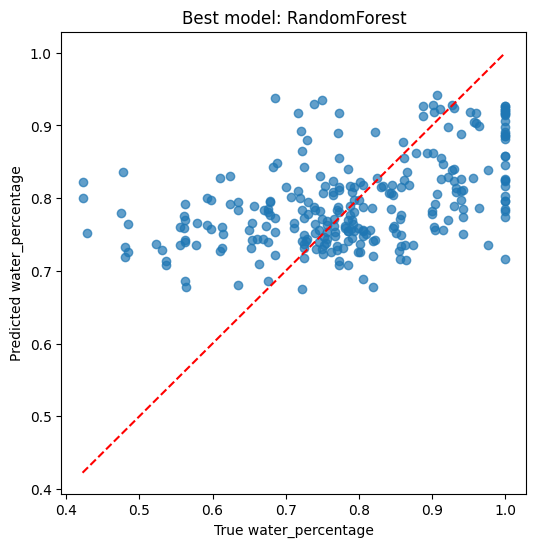

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import optuna
import matplotlib.pyplot as plt

# ---------------- Load dataset ----------------
file_path = r"C:\Users\ritaj\Documents\R\Rabanitos\datasets\dataset_completo.xlsx"
df = pd.read_excel(file_path)

features = [
    'ASM (Energy)', 'Contrast', 'Correlation', 'Variance',
    'IDM (Homogeneity)', 'Sum Average', 'Sum Variance', 'Sum Entropy',
    'Entropy', 'Difference Variance', 'Difference Entropy',
    'IMC1 (Info Measure Corr 1)', 'IMC2 (Info Measure Corr 2)'
]
target_col = "water_percentage"

X = df[features]
y = df[target_col]

mask = ~(X.isna().any(axis=1) | y.isna())
X = X[mask]
y = y[mask]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ---------------- Define objective functions for Optuna ----------------
def objective_rf(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 500)
    max_depth = trial.suggest_int("max_depth", 2, 20)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 5)

    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return r2_score(y_test, y_pred)

def objective_gb(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 500)
    max_depth = trial.suggest_int("max_depth", 2, 10)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.5, log=True)
    subsample = trial.suggest_float("subsample", 0.5, 1.0)

    model = GradientBoostingRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        random_state=42
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return r2_score(y_test, y_pred)

# ---------------- Run Optuna studies ----------------
studies = {
    "RandomForest": objective_rf,
    "GradientBoosting": objective_gb
}

best_models = {}
for name, objective in studies.items():
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=30, show_progress_bar=True)
    best_models[name] = study.best_trial
    print(f"\n{name} best R²: {study.best_value}")
    print("Best params:", study.best_params)

# ---------------- Train final best models ----------------
final_models = {}
for name, trial in best_models.items():
    if name == "RandomForest":
        model = RandomForestRegressor(**trial.params, random_state=42)
    elif name == "GradientBoosting":
        model = GradientBoostingRegressor(**trial.params, random_state=42)
    model.fit(X_train, y_train)
    final_models[name] = model
    y_pred = model.predict(X_test)
    print(f"\n{name} final test R²:", r2_score(y_test, y_pred))

# ---------------- Plot predicted vs true for best model ----------------
best_model_name = max(final_models, key=lambda k: r2_score(y_test, final_models[k].predict(X_test)))
y_pred_best = final_models[best_model_name].predict(X_test)

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_best, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("True water_percentage")
plt.ylabel("Predicted water_percentage")
plt.title(f"Best model: {best_model_name}")
plt.show()

